In [22]:
import os
import io
import zipfile
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from pyproj import Proj, transform

from sklearn import preprocessing
from sklearn.cluster import KMeans

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

pd.set_option('display.max_columns', 500)
style.use('fivethirtyeight')
%matplotlib inline

In [23]:

ll84_urls = {
    '2016': "http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx",
    '2015': "http://www.nyc.gov/html/gbee/downloads/excel/2015_nyc_cy2014__ll84_disclosure_data.xlsx",
    '2014': "http://www.nyc.gov/html/gbee/downloads/excel/150428_2014_nyc_ll84_disclosure.xlsx",
    '2013': "http://www.nyc.gov/html/gbee/downloads/excel/2013_nyc_ll84_disclosure.xlsx",
#     '2012': "http://www.nyc.gov/html/gbee/downloads/excel/2012_nyc_cy2011_ll84_disclosure_data.xls"
}

PLUTO_cache = 'data/pluto16.csv'
PLUTO_url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip'

In [44]:
if os.path.isfile(PLUTO_cache):
    # Read from cache
    df_pluto = pd.read_csv(PLUTO_cache)
else:
    print('Downloading...')
    
    remotezip = urllib.urlopen(PLUTO_url).read()
    with zipfile.ZipFile(io.BytesIO(remotezip)) as z:
        df_pluto = pd.concat([
            pd.read_csv(z.open(f))
            for f in z.namelist()
            if os.path.splitext(f)[1] == '.csv'
        ])
    
    df_pluto.to_csv(PLUTO_cache, index=False)
    
df_pluto = df_pluto[['BBL', 'Borough','LotArea', 'BldgArea', 'ComArea', 'ResArea', 
                     'OfficeArea', 'RetailArea', 'NumFloors', 'UnitsRes', 'UnitsTotal', 
                     'YearBuilt', 'XCoord', 'YCoord', 'ZipCode', 'Address']]
    
print(df_pluto.shape)
df_pluto.head()

(631890, 16)


,BBL,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address
0,3.000010e+09,BK,151930,0,0,0,0,0,0.0,0,0,0,NaN,NaN,11201.0,JOHN STREET
1,3.000010e+09,BK,19682,154400,154400,0,17160,0,9.0,0,90,1920,987838.0,195989.0,11201.0,10 JAY STREET
2,3.000018e+09,BK,0,102534,4686,97848,0,4686,12.0,42,44,0,987624.0,195992.0,11201.0,1 JOHN STREET
3,3.000030e+09,BK,387060,0,0,0,0,0,0.0,0,0,0,988568.0,196151.0,11201.0,JAY STREET
4,3.000030e+09,BK,6384,0,0,0,0,0,0.0,0,0,0,NaN,NaN,11201.0,JAY STREET


In [45]:
dfs_ll84 = {}
for year, url in ll84_urls.items():
    local_fname = 'data/LL84_{}.csv'.format(year)
    if os.path.isfile(local_fname):
        dfs_ll84[year] = pd.read_csv(local_fname)
    else:
        dfs_ll84[year] = pd.read_excel(url)
        dfs_ll84[year].to_csv(local_fname, encoding='utf-8')
dfs_ll84.keys()

['2015', '2014', '2016', '2013']

In [46]:
dfs_ll84['2016'].columns

Index([u'Unnamed: 0', u'Record Number', u'Order',
       u'NYC Borough, Block and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft²)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft²)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft²)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft²)',
  

In [47]:
# Keep BBL, Energy, and Floor Data

keepCol = ['BBL', 'Site EUI\n(kBtu/ft2)', 'Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2013'] = dfs_ll84['2013'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2013', 'floorArea_2013'])))

keepCol = ['NYC Borough, Block, and Lot (BBL)', 'Site EUI\n(kBtu/ft2)', 
           'DOF Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2014'] = dfs_ll84['2014'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2014', 'floorArea_2014'])))

keepCol = ['NYC Borough, Block, and Lot (BBL)', 'Site EUI\n(kBtu/ft2)',
          'DOF Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2015'] = dfs_ll84['2015'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2015', 'floorArea_2015'])))

keepCol = ['NYC Borough, Block and Lot (BBL)', r'Site EUI (kBtu/ft²)', r'DOF Property Floor Area (ft²)',
          'Primary Property Type - Self Selected']
dfs_ll84['2016'] = dfs_ll84['2016'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2016', 'floorArea_2016','TYPE_2016'])))

In [48]:
df84 = reduce(
    lambda df1, df2: df1.merge(df2, left_on='BBL', right_on='BBL', how='left'),
    [dfs_ll84[year] for year in sorted(dfs_ll84.keys())]
)
df84.head()

,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,TYPE_2016
0,1000010010,NaN,NaN,NaN,2725731.0,NaN,2725731.0,NaN,NaN,NaN
1,1000020002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000047501,102.0,2428325.0,92.5,2621563.0,149,2542563.0,133.8,2542563.0,Office
3,1000057501,119.6,1338000.0,134.5,1354691.0,113.8,1354691.0,135.8,1354691.0,Office
4,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,See Primary BBL


In [49]:
df = df84.merge(df_pluto, on='BBL', how='left')
df.head()

,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,TYPE_2016,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address
0,1000010010,NaN,NaN,NaN,2725731.0,NaN,2725731.0,NaN,NaN,NaN,MN,7736692.0,2725731.0,2725731.0,0.0,0.0,0.0,0.0,0.0,0.0,1900.0,979071.0,190225.0,10004.0,1 GOVERNORS ISLAND
1,1000020002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN,191502.0,158197.0,158197.0,0.0,0.0,0.0,5.0,0.0,0.0,1900.0,981037.0,194506.0,10004.0,10 SOUTH STREET
2,1000047501,102.0,2428325.0,92.5,2621563.0,149,2542563.0,133.8,2542563.0,Office,MN,111382.0,1888126.0,1888126.0,0.0,1848626.0,39500.0,50.0,0.0,52.0,1969.0,980917.0,195090.0,10004.0,1 WATER STREET
3,1000057501,119.6,1338000.0,134.5,1354691.0,113.8,1354691.0,135.8,1354691.0,Office,MN,54023.0,1024229.0,1024229.0,0.0,1024229.0,0.0,40.0,0.0,7.0,1970.0,981309.0,195131.0,10004.0,125 BROAD STREET
4,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,See Primary BBL,MN,258600.0,458591.0,620.0,457971.0,0.0,620.0,6.0,586.0,590.0,1948.0,991053.0,202591.0,10009.0,134 AVENUE D


In [96]:
print(df.shape)
df = df.dropna()
print(df.shape)

(17914, 25)
(9872, 25)


In [52]:
df['Longitude'], df['Latitude'] = transform(
    Proj(init='epsg:2263', preserve_units=True), # ny/li projection
    Proj(init='epsg:4326'), # wgs84 projection
    df.XCoord.values, df.YCoord.values# x, y
)

df[['Address', 'Latitude', 'Longitude']].head()

,Address,Latitude,Longitude
0,1 GOVERNORS ISLAND,40.688799,-74.018675
1,10 SOUTH STREET,40.700550,-74.011588
2,1 WATER STREET,40.702153,-74.012021
3,125 BROAD STREET,40.702266,-74.010607
4,134 AVENUE D,40.722740,-73.975457


In [53]:
df.to_csv('merged-w-latlon.csv', index=False)

In [97]:
def clean(df, col='eui', use_log=True, nonneg=False, nstd=2):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    try:
        if nonneg:
            df = df[df[col] >= 0]
        if use_log:
            df = df[df[col] != 0]
            vals = np.log10(df[col].astype(float))
        else:
            vals = df[col].astype(float)
    except ValueError:
        return df
    
    if nstd:
        return df[ (np.abs(vals - np.mean(vals)) < nstd*np.std(vals)) ]
    return df

## Add further data processing...

In [137]:
def makeCorrPlots(x, y, df, log=False):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    try:
        tmp = df[[x,y]]
        tmp = tmp.dropna()
        X, Y = tmp[x].astype(float), tmp[y].astype(float)
    except:
        print(x, y)
        return
    
    if not len(X) or not len(Y):
        return
    
    if log:
        X[X == 0] = 1e-12;
        X = np.log10(X)
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(X, Y)
    
    # plot2
    plt.scatter(X, Y, color='b', alpha=0.5)
    plt.plot(X, intercept + slope*X, color='firebrick')
    plt.title('{} v. {}{} (corr= {:.2f})'.format(y, 'log ' if log else '', x, np.corrcoef(X, Y)[0][1]))

In [151]:
eui_cols = {col for col in df.columns if 'eui' in col.lower()}
non_eui_cols = set(df.columns) - eui_cols
eui_cols, non_eui_cols = list(eui_cols), list(non_eui_cols)

plot_cols = 'LotArea	BldgArea	ComArea	ResArea	OfficeArea	RetailArea	NumFloors	UnitsRes	UnitsTotal'.split('\t')

In [152]:
df2 = pd.concat([
    df[plot_cols + ['EUI_{}'.format(y), 'floorArea_{}'.format(y)]].rename(columns={
        'EUI_{}'.format(y): 'EUI',
        'floorArea_{}'.format(y): 'floorArea'
    })
    for y in [2013, 2014, 2015, 2016]
])

df2 = df2[df2.EUI != 'Not Available']
df2.EUI = pd.to_numeric(df2.EUI)

print(df2.dtypes)
df2.head()

LotArea       float64
BldgArea      float64
ComArea       float64
ResArea       float64
OfficeArea    float64
RetailArea    float64
NumFloors     float64
UnitsRes      float64
UnitsTotal    float64
EUI           float64
floorArea     float64
dtype: object


,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,EUI,floorArea
44,37248.0,428589.0,4750.0,423839.0,1640.0,3110.0,44.0,545.0,547.0,91.6,517639.0
81,16100.0,238204.0,83720.0,154484.0,39762.0,43958.0,31.0,156.0,165.0,63.5,242953.0
93,24524.0,724299.0,289022.0,435277.0,252136.0,36886.0,57.0,350.0,352.0,27.7,826289.0
184,16642.0,222000.0,23500.0,198500.0,15000.0,8500.0,28.0,189.0,194.0,54.3,240421.0
187,14851.0,344914.0,130550.0,214364.0,97912.0,32638.0,29.0,221.0,222.0,55.4,410482.0


In [153]:
for col in plot_cols:
    df = clean(df, col, nstd=0, nonneg=True)
    df2 = clean(df2, col, nstd=0, nonneg=True)
    
for col in eui_cols:
    df = clean(df, col, nstd=4, nonneg=True)
df2 = clean(df2, 'EUI', nstd=4, nonneg=True)

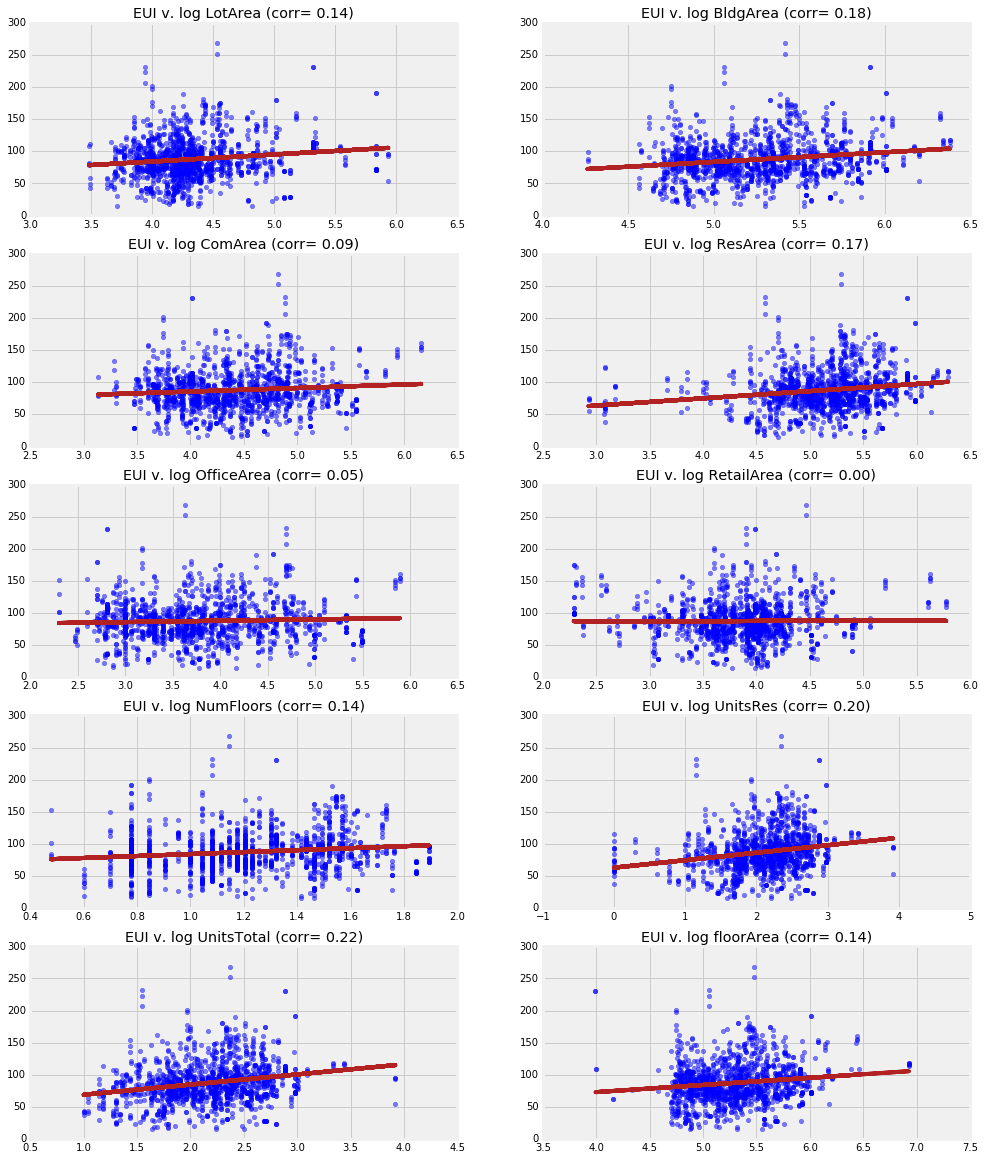

In [156]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(plot_cols + ['floorArea'], 1):
    if not col in df2.columns:
        continue
    plt.subplot(5, 2, i)
    makeCorrPlots(col, 'EUI', df2, log=True)

## Add OLS here....